In [7]:
import sys
from pathlib import Path
import torch
import numpy as np
import py3Dmol
import os
from rdkit import Chem
import pandas as pd
import ast

basedir = Path("/home/domainHomes/ssakharov/master_thesis/crossdocked/processed_crossdock_noH_ca_only_temp")

models = []
models.append(basedir / "predictions_r10_t50")
models.append(basedir / "predictions_r1_t500_n100_second")
models.append(basedir / "predictions_r1_t500_ddim_50_nu_0_n100_quad")
models.append(basedir / "predictions_r1_t500_ddim_100_nu_0_n100_quad")
models.append(basedir / "predictions_r1_t500_ddim_250_nu_0_n100_quad")
models.append(basedir / "predictions_r1_t500_ddim_400_nu_0_n100_quad")


In [8]:
def get_top_10(qvina, metric2):
    idx_set_0 = np.where(qvina > 0)
    qvina[idx_set_0] = 0
    metric2[idx_set_0] = 0
    qvina_temp = np.abs(qvina)
    norm_sum = qvina_temp / np.max(qvina_temp) + metric2 / np.max(metric2)
    sorted_idx = np.argsort(norm_sum)
    best_idx = sorted_idx[-10:]
    return qvina[best_idx], metric2[best_idx]


def get_random_molecule_file(path):
    path = path / "processed"
    return np.random.choice(os.listdir(path))

def get_molecules(basedir, models, mol_name, top10):
    mols_per_model = []
    qvina_per_model = []
    qed_per_model = []
    sa_per_model = []
    for model in models:
        mol_path = basedir / model / "processed" /mol_name
        with open(mol_path, "r") as f:
            mols_str = f.read().split("$$$$\n")[0:-1]
        qvina = read_qvina_scores(basedir / model, mol_name)
        qed, sa = get_other_metrics(basedir / model, mol_name)
        assert len(mols_str) == len(qvina) == len(qed) == len(sa)
        if top10 == "sa":
            qvina, sa = get_top_10(qvina, sa)
        elif top10 == "qed":
            qvina, qed = get_top_10(qvina, qed)
        mols_per_model.append(mols_str)
        qvina_per_model.append(qvina)
        qed_per_model.append(qed)
        sa_per_model.append(sa)
    return mols_per_model, qvina_per_model, qed_per_model, sa_per_model

def read_qvina_scores(path, mol_name):
    qvina_file = path / "qvina" / "qvina2_scores.csv"
    if not qvina_file.exists():
        return None
    df = pd.read_csv(qvina_file, index_col=0)
    # df["scores"] = df["scores"].apply(lambda x: np.array(ast.literal_eval(x.replace("nan, ", "").replace(", nan]", "]"))))
    df["ligand_name"] = df["ligand"].apply(lambda x: x.split("/")[-1])
    df_filtered = df[df["ligand_name"] == mol_name].copy()
    df_filtered["scores"] = df_filtered["scores"].apply(lambda x: np.array(ast.literal_eval(x.replace("nan", "0"))))
    return df_filtered["scores"].values[0]

def get_true_molecule(basedir, mol_name):
    mol_path = basedir / "test" / mol_name.replace("_gen", "")
    with open(mol_path, "r") as f:
        mols_str = f.read()
    return mols_str

def get_other_metrics(path, mol_name):
    df_metric = pd.read_csv(path / "metrics.csv", header=0)
    df_metric_mol = df_metric[df_metric["file_names"] == mol_name]
    qed = ast.literal_eval(df_metric_mol["QED"].values[0][1:-1].replace("None", "0"))
    sa = ast.literal_eval(df_metric_mol["SA"].values[0][1:-1].replace("None", "0"))
    return np.array(qed), np.array(sa)

In [9]:
qvina_per_model = []
qed_per_model = []
sa_per_model = []
molecules = os.listdir(models[0] / "processed")
top10 = "qed"
for mol in molecules:
    _, qvina, qed, sa = get_molecules(basedir, models, mol, top10=top10)
    qvina, qed, sa = np.array(qvina), np.array(qed), np.array(sa)
    qvina_per_model.append(qvina)
    qed_per_model.append(qed)
    sa_per_model.append(sa)
        
qvina_per_model, qed_per_model, sa_per_model = np.array(qvina_per_model), np.array(qed_per_model), np.array(sa_per_model)
print(qvina_per_model.shape, qed_per_model.shape, sa_per_model.shape)
qvina_per_model = qvina_per_model.swapaxes(0,1).reshape(len(models), -1)
qed_per_model = qed_per_model.swapaxes(0,1).reshape(len(models), -1)
sa_per_model = sa_per_model.swapaxes(0,1).reshape(len(models), -1)
print(qvina_per_model.shape, qed_per_model.shape, sa_per_model.shape)


(100, 6, 10) (100, 6, 10) (100, 6, 100)
(6, 1000) (6, 1000) (6, 10000)


qvina (1000,), metric (1000,)
qvina (1000,), metric (1000,)
qvina (1000,), metric (1000,)
qvina (1000,), metric (1000,)
qvina (1000,), metric (1000,)
qvina (1000,), metric (1000,)


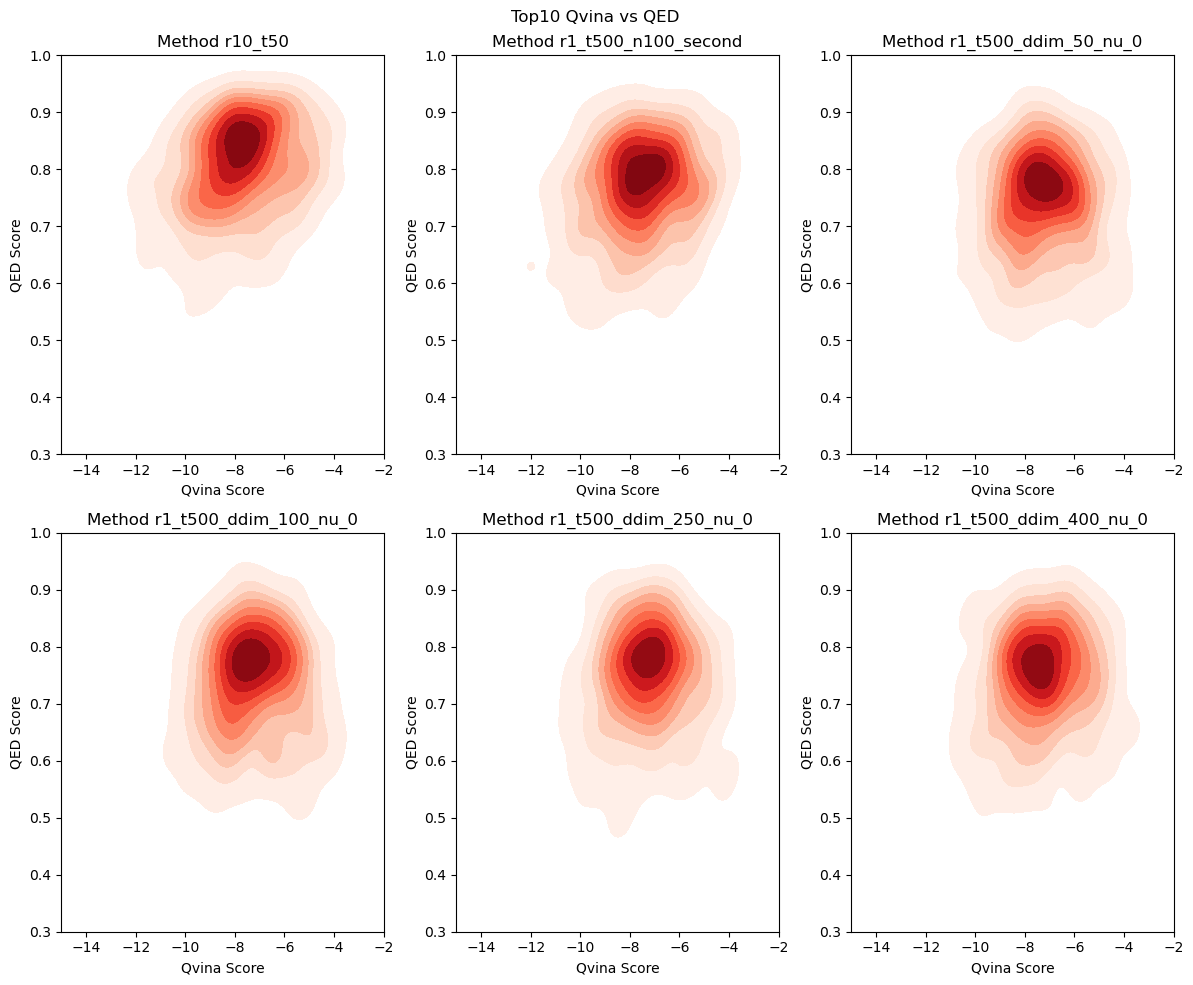

In [10]:
#### plot qvina vs qed on sigle plot
import matplotlib.pyplot as plt
import seaborn as sns
rows = 2
cols = np.ceil(len(models) / rows).astype(int)
fig, axs = plt.subplots(rows, cols, figsize=(12, 10))  # Create a 2x2 grid of plots
axs = axs.flatten()  # Flatten the 2x2 grid into a 1D array for easier access
metric_per_model = sa_per_model if top10 == "sa" else qed_per_model
for i, model in enumerate(models):
    qvina_scores = qvina_per_model[i]
    metric_scores = metric_per_model[i]
    ### filter out zeros
    indices = np.where((qvina_scores < 0) & (metric_scores > 0))
    qvina_scores = qvina_scores[indices]
    metric_scores = metric_scores[indices]
    print(f"qvina {qvina_scores.shape}, metric {metric_scores.shape}")
    sns.kdeplot(x=qvina_scores, y=metric_scores, ax=axs[i], cmap="Reds", fill=True)
    # sns.scatterplot(x=qvina_scores, y=metric_scores, ax=axs[i], color="blue", alpha=0.5)
    axs[i].set_title(f'Method {model.name.replace("predictions_", "").replace("_n100_quad", "")}')
    axs[i].set_xlabel('Qvina Score')
    axs[i].set_ylabel(f'{"QED" if top10=="qed" else "SA" } Score')
    if top10 == "qed":
        axs[i].set_xlim(-15, -2)
        axs[i].set_ylim(0.3, 1)
    elif top10 == "sa":
        axs[i].set_xlim(-15, -2)
        axs[i].set_ylim(0.3, 1.2)
plt.suptitle(f'Top10 Qvina vs {"QED" if top10=="qed" else "SA" }')
plt.tight_layout()